# Research sprint summary: Sam and Adam

Following [Geiger et al. (2023)](https://arxiv.org/abs/2303.02536).

## Overview

### High level summary
- Created large codebase (~3000 lines) that runs flexibly with arbitrary DAGs and Transformerlens
- Created a new type of DAG specific for the transformer architecture, with stream-tied rotations, effectively testing the abstractness of the algorithm the transformer uses
- Reproduced hierarchical equality experiments from [Geiger et al. (2023)](https://arxiv.org/abs/2303.02536)
- Created clean dataset for parenthesis balancing task
- Tested stream-tied rotation matrix on parenthesis balancing task, though results were inconclusive
- Also created different DAGs that solve the task, but did not have time to test them

### Details of what we did

- Created big codebase (~3000 lines) that runs flexibly with arbitrary DAGs and Transformerlens
    * DAG computation modelling, and recurrent version
    * Interchange intervention: fixing some node values to those taken on source inputs,
      then running on a base input.
    * Alignment between DAG nodes and subspaces of neural networks using rotation
      matrices, also for transformers
    * Distributed interchange intervention: intervening on subspaces via DAG alignment
    * Generating dataset of interchange interventions
    * Training rotation matrix on this
    * Many efficiency improvements were needed to make things run 
- Reproduced hierarchical equality experiments from [Geiger et al.
  (2023)](https://arxiv.org/abs/2303.02536)
    * Got similar values to the top left quadrant of Table 1
- Cleaned dataset for parenthesis balancing
    * Chunking
    * Removing samples with weird parenthesis tokens (e.g. `(*!(`) 
- Created a new type of DAG specific for the transformer architecture, with stream-tied rotations
    * Any DAG node is represented by the same subspace across all residual streams
    * Strong compression: mechanisms and computations for task are shared across
      streams. 
    * Intuitively this 
- Tested stream-tied rotation matrix on parenthesis balancing task
    * Results inconclusive: training was very slow
    * Could be because of a bug in the code
    * Could be because our proposed DAG isn't correct
    * Could be because hypothesis is wrong
* Created other DAGs for paren balancing, but did not yet have time to test them
  * Every stream has its own subspace
  * Stream-tied rotation matrices but accounting for special tokens that suppress the close parenthesis token only for the next token
  * Same as previous but not stream tied
- Weak points
    * Slow training on parenthesis balancing task
    * Didn't balance parenthesis balancing interchange intervention dataset to
      prioritise interesting interventions
    * Little experimental red-teaming
    * Some inefficiencies remain in the code
* Next steps
  * In general we feel we have a really great base to run many experiments now and collect a lot of data, which is great
  * The first thing to do would be to get the training of the rotation matrix to run faster
  * There are also a number of basic considerations we have to make to the intervention distributions. These are easy to do, but we didn't have time to do them
  * Then we would train rotation matrices on all DAGs for the paren balancing task, and on different parts of the transformer. Given our code base this is just a matter of changing a few lines of code
  * After that analysis we would attack the problem from the other side. That is, we would look at the activity in the rotated space and see if we can use the normal tools of "bottom-up" mechanistic interpretabiltiy to understand what is going on. This would make the top-down causal analysis more convincing to those who are skeptical of it, and more used to the bottom-up approach.If the rotated spaces are "real" then they should be extremely easy to interpret!!
  * Staying at the high-level though, there are a number of interesting questions having to do with the geometry of the activations in the rotated space, how that changes up the residual stream, how attention and MLPs influence that geometry, etc. that we find interesting
  * Atticus also brought up an idea having to do with a heirarchy of abstractions and finding those in the transformer. This is a very interesting idea that we would like to explore, and to some degree have it (though implicitly), in the relationship between the stream-tied rotation matrices and the untied version. (the stream-tied rotation DAG is a more abstracted version of the untied version, but the idea of abstract heirarchies is more general).
  * There are obviously many other ideas e.g. looking for shared causal variables between different tasks, but that would be much farther in the future.
  * For the moment the next steps seem pretty obvious to us

## Setup

In [1]:
RESULTS_DATA_DIR = "../results"
HIER_EQAL_PREFIX = "hier_eqal"
PAREN_BAL_PREFIX = "paren_bal"

In [2]:
import json
import os

import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as colors

from rich.table import Table
from rich.console import Console

from causal_networks.models import (
    make_hier_equal_dag_and_variable_alignment,
    make_paren_bal_dag_and_variable_alignment,
)

In [3]:
import plotly.io as pio
pio.renderers.default = "colab+vscode"

console = Console()

## Hierarchical equality 

### Task details

Given four 4-dimensional inputs $x_1$, $x_2$, $x_3$, $x_4$, determine whether $(x_1 = x_2) \text{ XNOR } (x_3 = x_4)$.

### Implementation details

- Following [Geiger et al. (2023)](https://arxiv.org/abs/2303.02536)
- We trained a three-layer model to obtain 100% accuracy on the task
- We test alignment with a simple DAG which solves the task

In [4]:
dag_he, variable_alignment_he, model_he = make_hier_equal_dag_and_variable_alignment(
    hidden_size=16,
    size_per_input=4,
    intervene_model_hooks=["hook_mid2"],
    intervene_nodes=["b1", "b2"],
    subspace_sizes=[8, 8],
    device="cpu",
)

Training the model...


  0%|          | 0/5000 [00:00<?, ?it/s]/home/sam/.virtualenvs/causal-networks/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning:

CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)

100%|██████████| 5000/5000 [01:31<00:00, 54.71it/s]

Final loss: 2.7243e-05. Final accuracy: 100.00000%
Running model to determine activation space size...


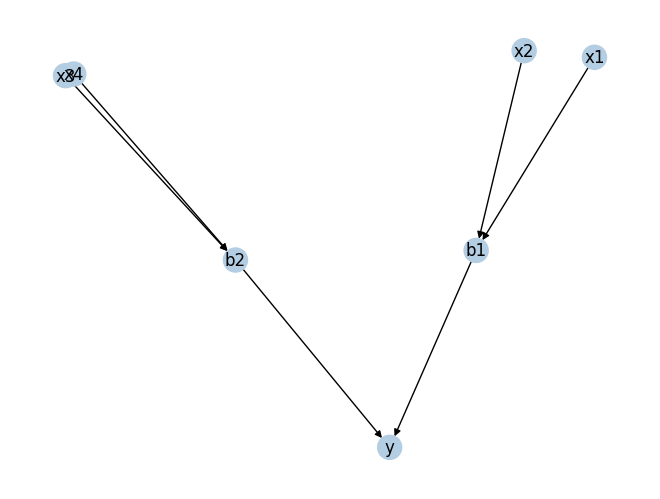

                           Node Information                            
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler ┃ Validator                   ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x2   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x3   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ x4   │ -            │ -       │ array_float_validator(-, 4) │ -     │
│ b1   │ compare_func │ -       │ bool_validator              │ -     │
│ b2   │ compare_func │ -       │ bool_validator              │ -     │
│ y    │ compare_func │ -       │ bool_validator              │ -     │
└──────┴──────────────┴─────────┴─────────────────────────────┴───────┘

In [5]:
dag_he.reset()
dag_he.visualize()

- Interchange intervention: fixing the value of nodes using source inputs, then running on a base input
- Below: intervene on "b1", so that the intervened model outputs differently on a base input

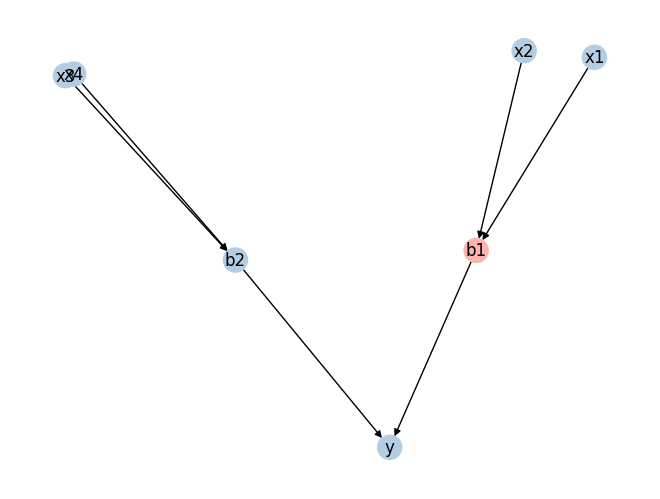

                                 Node Information                                  
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler ┃ Validator                   ┃ Value             ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x1   │ -            │ -       │ array_float_validator(-, 4) │ [0.1 0.1 0.1 0.1] │
│ x2   │ -            │ -       │ array_float_validator(-, 4) │ [0.2 0.2 0.2 0.2] │
│ x3   │ -            │ -       │ array_float_validator(-, 4) │ [0.1 0.1 0.1 0.1] │
│ x4   │ -            │ -       │ array_float_validator(-, 4) │ [0.2 0.2 0.2 0.2] │
│ b1   │ compare_func │ -       │ bool_validator              │ True              │
│ b2   │ compare_func │ -       │ bool_validator              │ False             │
│ y    │ compare_func │ -       │ bool_validator              │ False             │
└──────┴──────────────┴─────────┴─────────────────────────────┴───────────────────┘

In [6]:
value_1 = np.array([0.1] * 4)
value_2 = np.array([0.2] * 4)

dag_he.do_interchange_intervention(
    [["b1"]],
    [
        dict(
            x1=value_1,
            x2=value_1,
            x3=value_1,
            x4=value_1,
        )
    ],
)
dag_he.run(
    dict(
        x1=value_1,
        x2=value_2,
        x3=value_1,
        x4=value_2,
    ),
    reset=False,
)
dag_he.visualize()

### Experimental results

We considered intervening on the nodes "b1" and "b2" in different layers with different subspace sizes

In [7]:
data_he = []
for filename in os.listdir(RESULTS_DATA_DIR):
    filepath = os.path.join(RESULTS_DATA_DIR, filename)
    if os.path.isfile(filepath) and filename.startswith(HIER_EQAL_PREFIX):
        with open(filepath) as fp:
            data_he.append(json.load(fp))

In [8]:
intervene_hook = [
    "hook_mid1",
    "hook_mid2",
    "hook_mid3",
]
subspace_size = [1, 2, 4, 8]

train_accuracies_he = np.zeros((len(intervene_hook), len(subspace_size), len(data_he[0]["train_accuracies"])))
test_accuracies_he = np.zeros((len(intervene_hook), len(subspace_size)))
for datum in data_he:
    i = intervene_hook.index(datum["parameters"]["intervene_hook"])
    j = subspace_size.index(datum["parameters"]["subspace_sizes"][0])
    test_accuracies_he[i, j] = datum["test_accuracy"]
    train_accuracies_he[i, j] = np.array(datum["train_accuracies"])

The following lists the test accuracies we obtained after training the rotation matrix

In [9]:
table = Table(
    title="Test accuracies for interventions on b1 and b2", show_header=True, header_style="bold"
)
table.add_column("Hook", style="bold")
table.add_column("Subspace Sizes 1")
table.add_column("Subspace Sizes 2")
table.add_column("Subspace Sizes 4")
table.add_column("Subspace Sizes 8")
for i, hook in enumerate(intervene_hook[:2]):
    table.add_row(
        hook,
        f"{test_accuracies_he[i, 0]:.4f}",
        f"{test_accuracies_he[i, 1]:.4f}",
        f"{test_accuracies_he[i, 2]:.4f}",
        f"{test_accuracies_he[i, 3]:.4f}",
    )
console.print(table)

                     Test accuracies for interventions on b1 and b2                      
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Hook      ┃ Subspace Sizes 1 ┃ Subspace Sizes 2 ┃ Subspace Sizes 4 ┃ Subspace Sizes 8 ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ hook_mid1 │ 0.6650           │ 0.7170           │ 0.6910           │ 0.8700           │
│ hook_mid2 │ 0.8700           │ 0.8900           │ 0.9040           │ 0.9160           │
└───────────┴──────────────────┴──────────────────┴──────────────────┴──────────────────┘

Looking at the plots of train accuracy, we got to convergence for the second layer, but not the first, indicating that we should have kept going

In [10]:
import plotly.graph_objects as go

traces = []

# Iterate over the first two elements of intervene_hook
for i, hook in enumerate(intervene_hook[:2]):
    # Iterate over subspace_size
    for j, size in enumerate(subspace_size):
        # Get train accuracies for the current hook and size
        train_accuracies = train_accuracies_he[i, j]
        
        # Create a scatter trace for the train accuracies
        trace = go.Scatter(
            x=list(range(len(train_accuracies))),
            y=train_accuracies,
            name=f"{hook}, subspace size: {size}",
            mode="lines",
            visible=bool(1-i),
        )
        
        # Add the trace to the list of traces
        traces.append(trace)

# Create layout
layout = go.Layout(
    title="Hierarchical equality rotation matrix train accuracies",
    xaxis_title="Epoch",
    yaxis_title="Train Accuracy",
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label="hook_mid1",
                    method="update",
                    args=[{"visible": [True] * 4 + [False] *4}]
                ),
                dict(
                    label="hook_mid2",
                    method="update",
                    args=[{"visible": [False] * 4 + [True] *4}]
                )
            ],
            active=0,
            showactive=True
        )
    ]
)

# Create Figure object
fig = go.Figure(data=traces, layout=layout)

# Display the figure
fig.show()

## Parenthesis balancing

### Task details

Given a string, determine whether the next token is more likely to be an open or closed parenthesis

### Implementation details

- We used a pretrained 1-layer transformer ("gelu-1l")
- We developed a recurrent DAG to solve the task
- The implementation of the DAG allows it to apply to arbitrary length sequences

In [11]:
dag_pb, variable_alignment_pb, model_pb = make_paren_bal_dag_and_variable_alignment(
    model_name="gelu-1l",
    intervene_model_hooks=["blocks.0.hook_resid_mid"],
    intervene_nodes=["s"],
    subspace_sizes=[64],
    device="cpu",
)

Loaded pretrained model gelu-1l into HookedTransformer
Running model to determine activation space size...


Here we intervene on the DAG at a specific node and stream position, which changes the final output.

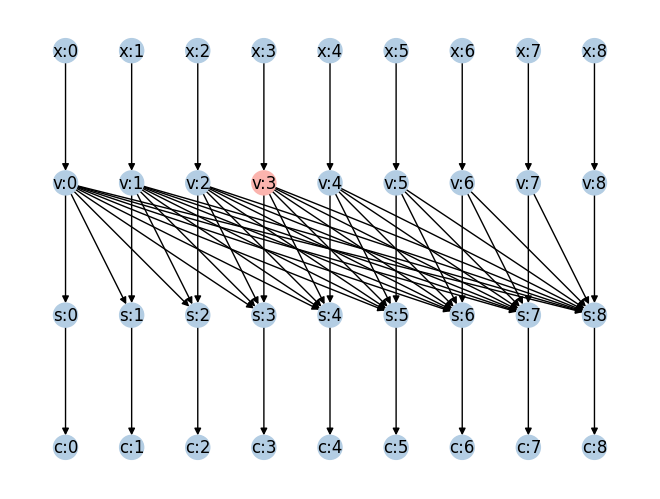

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function       ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃ Value 5 ┃ Value 6 ┃ Value 7 ┃ Value 8 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -              │ <|BOS|> │ (       │ d       │ (       │ d       │ )       │ d       │ )       │ d       │
│ v    │ interp_symbol… │ 0       │ 1       │ 0       │ -1      │ 0       │ -1      │ 0       │ -1      │ 0       │
│ s    │ cumsum_func    │ 0       │ 1       │ 1       │ 0       │ 0       │ -1      │ -1      │ -2      │ -2      │
│ c    │ close_paren_f… │ False   │ True    │ True    │ False   │ False   │ False   │ False   │ False   │ False   │
└──────┴────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [12]:
string1 = "(d(d)d)d"
string2 = "(d)d(d)d"

dag_pb.num_streams = 9
dag_pb.do_interchange_intervention([[("v", 3)]], [dict(x=model_pb.to_str_tokens(string2))])
dag_pb.run(dict(x=model_pb.to_str_tokens(string1)), reset=False)
dag_pb.visualize()

### Experimental results

In [13]:
data_pb = []
for filename in os.listdir(RESULTS_DATA_DIR):
    filepath = os.path.join(RESULTS_DATA_DIR, filename)
    if os.path.isfile(filepath) and filename.startswith(PAREN_BAL_PREFIX):
        with open(filepath) as fp:
            data_pb.append(json.load(fp))

In [14]:
intervene_node = ["v", "s"]
intervene_hook = [
    "blocks.0.hook_resid_pre",
    "blocks.0.hook_resid_mid",
    "blocks.0.hook_resid_post",
]
subspace_size = [64, 256]
train_lr = [1, 100, 10000]

test_accuracies_pb = np.zeros(
    (len(intervene_node), len(intervene_hook), len(subspace_size))
)
train_accuracies_pb = np.zeros(
    (
        len(intervene_node),
        len(intervene_hook),
        len(subspace_size),
        len(data_pb[0]["train_accuracies"]),
    )
)

# Select the best runs
for datum in data_pb:
    i = intervene_node.index(datum["parameters"]["intervene_node"])
    j = intervene_hook.index(datum["parameters"]["intervene_hook"])
    k = subspace_size.index(datum["parameters"]["subspace_size"])
    if datum["test_accuracy"] > test_accuracies_pb[i, j, k]:
        test_accuracies_pb[i, j, k] = datum["test_accuracy"]
        train_accuracies_pb[i, j, k] = np.array(datum["train_accuracies"])

The final test accuracies we obtained were quite low

In [17]:
table_v = Table(
    title="Accuracies for node 'v'", show_header=True, header_style="bold"
)
table_v.add_column("Hook", style="bold")
table_v.add_column("Subspace Size 64")
table_v.add_column("Subspace Size 256")
for j, hook in enumerate(intervene_hook):
    table_v.add_row(
        hook,
        f"{test_accuracies_pb[0, j, 0]:.4f}",
        f"{test_accuracies_pb[0, j, 1]:.4f}",
    )

table_s = Table(
    title="Accuracies for node 's'", show_header=True, header_style="bold"
)

table_s.add_column("Hook", style="bold")
table_s.add_column("Subspace Size 64")
table_s.add_column("Subspace Size 256")
for j, hook in enumerate(intervene_hook):
    table_s.add_row(
        hook,
        f"{test_accuracies_pb[1, j, 0]:.4f}",
        f"{test_accuracies_pb[1, j, 1]:.4f}",
    )

console.print(table_v, table_s, justify="center")

                      Accuracies for node 'v'                                              
                        ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓                        
                        ┃ Hook                     ┃ Subspace Size 64 ┃ Subspace Size 256 ┃                        
                        ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩                        
                        │ blocks.0.hook_resid_pre  │ 0.4774           │ 0.4772            │                        
                        │ blocks.0.hook_resid_mid  │ 0.4749           │ 0.4733            │                        
                        │ blocks.0.hook_resid_post │ 0.4744           │ 0.0000            │                        
                        └──────────────────────────┴──────────────────┴───────────────────┘                        
                                              Accuracies for node 's'                                              
                        ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓                        
                        ┃ Hook                     ┃ Subspace Size 64 ┃ Subspace Size 256 ┃                        
                        ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩                        
                        │ blocks.0.hook_resid_pre  │ 0.3851           │ 0.3751            │                        
                        │ blocks.0.hook_resid_mid  │ 0.3599           │ 0.3578            │                        
                        │ blocks.0.hook_resid_post │ 0.0000           │ 0.0000            │                        
                        └──────────────────────────┴──────────────────┴───────────────────┘

Looking at the loss curves, it's clear that the rotation matrix is training very slowly

In [16]:
traces = []

for i, node in enumerate(intervene_node):
    for j, hook in enumerate(intervene_hook):
        for k, size in enumerate(subspace_size):
    
            train_accuracies = train_accuracies_pb[i, j, k]
            
            # Create a scatter trace for the train accuracies
            trace = go.Scatter(
                x=list(range(len(train_accuracies))),
                y=train_accuracies,
                name=f"node: {node}, {hook}, subspace size: {size}",
                mode="lines",
                visible=bool(1-i),
            )
            
            # Add the trace to the list of traces
            traces.append(trace)

# Create layout
layout = go.Layout(
    title="Parenthesis balancing rotation matrix train losses",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label="Node v",
                    method="update",
                    args=[{"visible": [True] * 6 + [False] *6}]
                ),
                dict(
                    label="Node s",
                    method="update",
                    args=[{"visible": [False] * 6 + [True] *6}]
                )
            ],
            active=0,
            showactive=True
        )
    ]
)

fig = go.Figure(data=traces, layout=layout)
fig.show()